In this notebook, I explore the analysis of system dynamics using the FitzHugh–Nagumo model as an example. I was inspired by an exercise from the Neural Dynamics book (https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/phase-plane-analysis.html#q-traj2), from which I adapted and implemented the model.

My goal was to investigate the different types of bifurcations that can occur in this system. To do so, I slightly modified the original code. As a result, this notebook demonstrates how I examine both Hopf and saddle-node bifurcations in the FitzHugh–Nagumo model.

In [226]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from neurodynex3.phase_plane_analysis import fitzhugh_nagumo

## Andronov-Hopf Bifurcation

The system:
$$\begin{align*}
\frac{du}{dt} &= u - u^3 - w + I \\
\frac{dw}{dt} &= \varepsilon (u + 0.5a - 0.5 w)
\end{align*}$$
can exhibit two types of long-term behavior: it either converges to a stable fixed point or settles into a limit cycle.

In [309]:
u0 = -0.5 # initial condition for u
w0 = 1 # initial condition for w
eps = 0.1 # recovery parameter

In [307]:
def plot(I = 0):
    # plot the phase plane
    fitzhugh_nagumo.plot_flow(I_ext=I, eps=eps, a=2) 

    # plot the trajectory based on given initial conditions
    t, u, w = fitzhugh_nagumo.get_trajectory(v0=u0, w0=w0, I_ext=I) 

    x = np.arange(-2.5, 2.51, .1) 
    y = -x**3 + x + I
    plt.plot(x, y, color='black') 

    y = x + 2
    plt.plot(x, y, color='black') 

    plt.plot(u, w)

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 5.5) 
    plt.xlabel('u')
    plt.ylabel('w')
    
    return u

array([ 0.       , -0.02     , -0.0423992, ..., -0.6823278, -0.6823278,
       -0.6823278])

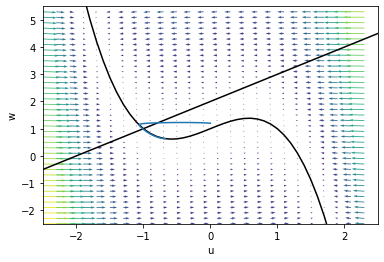

In [300]:
# The case with stable point
plot(I = 1)

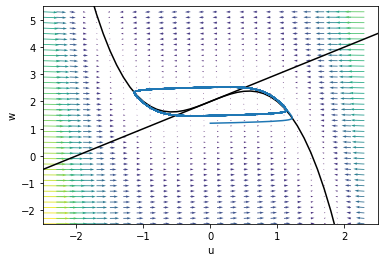

In [301]:
# The case with the limit cycle
u = plot(I = 2)

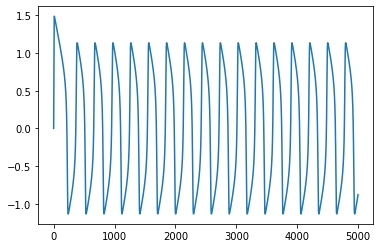

In [239]:
# we can see this ciclic activity here
plt.figure()
plt.plot(u)

Between the first and second cases, the system undergoes a bifurcation. First, let’s calculate the eigenvalues of the Jacobian matrix evaluated at the fixed points.

In [250]:
def get_jacobian(u0, w0, eta):
    # calculates the jacobian of the system above
    return np.array([[(1 - 3*u0**2), -1], [eta, -eta/2]])

Is = np.linspace(-4, 4, 21)
eigvals = np.zeros((len(Is), 2), dtype=complex)

for ind, I in enumerate(Is):
    # The function below finds fixed points of this system
    u0, w0 = fitzhugh_nagumo.get_fixed_point(I_ext=I, eps=eta, a=2.0)
    J = get_jacobian(u0, w0, eta)

    eigvals[ind] = np.linalg.eigvals(J)

In [251]:
# at fixed points
for I, eigvals in zip(Is, eigvals):
    print(f"For current {I:.2f} eigenvalues: {eigvals[0]:.3f} and {eigvals[1]:.3f}")

For current -4.00 eigenvalues: -6.999+0.000j and -0.064+0.000j
For current -3.60 eigenvalues: -6.558+0.000j and -0.065+0.000j
For current -3.20 eigenvalues: -6.107+0.000j and -0.067+0.000j
For current -2.80 eigenvalues: -5.645+0.000j and -0.068+0.000j
For current -2.40 eigenvalues: -5.170+0.000j and -0.070+0.000j
For current -2.00 eigenvalues: -4.682+0.000j and -0.072+0.000j
For current -1.60 eigenvalues: -4.178+0.000j and -0.074+0.000j
For current -1.20 eigenvalues: -3.656+0.000j and -0.078+0.000j
For current -0.80 eigenvalues: -3.113+0.000j and -0.083+0.000j
For current -0.40 eigenvalues: -2.546+0.000j and -0.090+0.000j
For current 0.00 eigenvalues: -1.947+0.000j and -0.103+0.000j
For current 0.40 eigenvalues: -1.305+0.000j and -0.130+0.000j
For current 0.80 eigenvalues: -0.523+0.000j and -0.261+0.000j
For current 1.20 eigenvalues: -0.051+0.316j and -0.051-0.316j
For current 1.60 eigenvalues: 0.399+0.000j and 0.173+0.000j
For current 2.00 eigenvalues: 0.894+0.000j and 0.056+0.000j
Fo

Somewhere between 1.2 and 1.6 the system becomes unstable and returns to stable state between 2.4 and 2.8. Let's explore this bifurcation mathematically

The characteristic equation for the eigenvalues is:
$$\lambda^2 - (1 - 3u_0^2 - \epsilon/2)\lambda + \epsilon/2(1 + 3u_0^2) = 0$$
For a Hopf bifurcation to occur, it is sufficient that the trace of the Jacobian is zero while the determinant is positive. This condition reduces to: $1 - 3u_0^2 - \epsilon/2 = 0$ which gives $u_0 = \pm \sqrt{\frac{19}{60}}$ Corresponding to these values of u0 the parameter I at the bifurcation points is approximately $I \approx 2.74$ and $I \approx 1.259$

### Saddle-Node Bifurcation

The system above cannot exhibit a saddle-node bifurcation because it has only one equilibrium point. To explore more complex dynamics, I need to modify the system slightly by introducing an additional parameter b

$$\begin{align*}
\frac{du}{dt} &= u - u^3 - w + I \\
\frac{dw}{dt} &= \varepsilon (u + 0.5a + bw)
\end{align*}$$

In [53]:
 def get_trajectory(v0=0., w0=0., I_ext=0., eps=0.1, a=2.0, b=0.5, tend=500.):
    eqs = """
    I_e : amp
    dv/dt = 1/ms * ( v * (1 - (v**2) / (mV**2) ) - w + I_e * Mohm ) : volt
    dw/dt = eps/ms * (v + b * (a * mV - w)) : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="euler")

    # state initialization
    neuron.v = v0 * b2.mV
    neuron.w = w0 * b2.mV

    # set input current
    neuron.I_e = I_ext * b2.nA

    # record states
    rec = b2.StateMonitor(neuron, ["v", "w"], record=True)

    # run the simulation
    b2.run(tend * b2.ms)

    return (rec.t / b2.ms, rec.v[0] / b2.mV, rec.w[0] / b2.mV)

def plot_flow(I_ext=0., eps=0.1, a=2.0, b=0.5):
    """Plots the phase plane of the Fitzhugh-Nagumo model
    for given model parameters.

    Args:
        I: Constant input [mV]
        eps: Inverse time constant of the recovery variable w [1/ms]
        a: Offset of the w-nullcline [mV]
    """

    # define the interval spanned by voltage v and recovery variable w
    # to produce the phase plane
    vv = np.arange(-2.5, 2.5, 0.2)
    ww = np.arange(-2.5, 5.5, 0.2)
    (VV, WW) = np.meshgrid(vv, ww)

    # Compute derivative of v and w according to FHN equations
    # and velocity as vector norm
    dV = VV * (1. - (VV**2)) - WW + I_ext
    dW = eps * (VV + b * (a - WW))
    vel = np.sqrt(dV**2 + dW**2)

    # Use quiver function to plot the phase plane
    plt.quiver(VV, WW, dV, dW, vel)
    
def get_fixed_point(I_ext=0., eps=0.1, a=2.0, b=0.5):
    # Use poly1d function from numpy to compute the
    # roots of 3rd order polynomial
    P = np.poly1d([1, 0, (1/b-1), (a - I_ext)], variable="x")

    # take only the real root
    v_fp = P.r
    w_fp = 2. * v_fp + a

    return zip(v_fp, w_fp)

array([101.,  99.])

In [348]:
u0 = 1 # initial conditions
w0 = 1 # initial conditions
b = 1.5 # parameter
a = 0 # parameter
eps = 0.1

As you can see, this time the nullclines intersect at three points, indicating the presence of multiple equilibria.

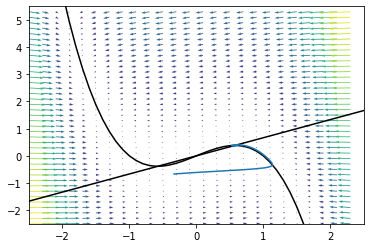

In [366]:
def plot_ext(I, a, b, eps, u0, w0):
    plot_flow(I_ext=I, eps=eps, a=a, b=b)


    t, u, w = get_trajectory(v0=u0, w0=w0, I_ext=I, eps=eps, a=a, b=b)

    x = np.arange(-2.5, 2.51, .1) 
    y = -x**3 + x + I
    plt.plot(x, y, color='black') 

    y = x/b + a
    plt.plot(x, y, color='black') 

    plt.plot(u, w)

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 5.5) 
    
plot_ext(0, a, b, eps, u0, w0)

In [355]:
# in this example we have two stable nodes and one unstable 
fixed_points = get_fixed_point(I_ext=I, eps=eta, a=a, b=b)
for u0, w0 in fixed_points:

    J = get_jacobian(u0, w0, eta)
    eigenval = np.linalg.eigvals(J)
    print(f"First eigenvalue: {eigenval[0]:.2f}, second {eigenval[1]:.2f}")

First eigenvalue: -0.03+0.32j, second -0.03-0.32j
First eigenvalue: -0.03+0.32j, second -0.03-0.32j
First eigenvalue: 0.89, second 0.06


Resolving the system with parameter b = 1.5 leads to the cubic equation:
$$u^3 - \frac{u}{3} = I$$

A saddle-node bifurcation occurs when two fixed points merge into one, which corresponds to the equation having a repeated root. This happens when the cubic has only two real roots, i.e., the discriminant is zero.

$-4(-1/3)^2 - 27I^2 = 0$ therefore $I = \pm\frac{2}{27}$

AT I = 2/27 the corresponding root is u = -1/3 and for I = -2/27 u = 1/3 

Calculating the eigenvalues of the Jacobian at these points, one eigenvalue is zero, which is a hallmark of a saddle-node bifurcation.

Although the nondegeneracy and transversality conditions are beyond the scope of this notebook, they are satisfied here, confirming the presence of a saddle-node bifurcation

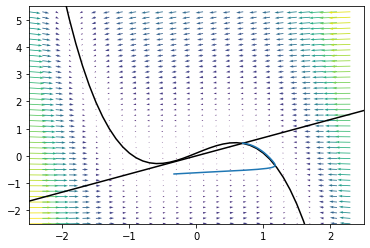

In [367]:
plot_ext(0.1, a, b, eps, u0, w0)

As we can see, after the saddle-node bifurcation, the system converges to a stable node.